In [1]:
import ast
from itertools import repeat
from pathlib import Path
import pickle

import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
from IPython.display import display
from sklearn.linear_model import LinearRegression
from tqdm.notebook import tqdm, trange
import seaborn as sns

from gradient_coding import GradientCoding
from multiplexed_sgc import MultiplexedSGC
from selective_repeat_sgc import SelectiveRepeatSGC
from no_coding import NoCoding
from utils import get_durations, load_profile, slugify, cdf, \
    folder_params, DELAY_DIR, ridge_plot

models = {
    'GC': GradientCoding,
    'SRSGC': SelectiveRepeatSGC,
    'MSGC': MultiplexedSGC,
    'No Coding': NoCoding,
}

FIG_DIR = Path('./')


In [70]:
# Plot themes

colors = {
    'GC': 'tab:blue',
    'SRSGC': 'tab:green',
    'MSGC': 'tab:orange',
    'No Coding': 'tab:red'
}

rc = {}

rc['axes.linewidth'] = 0.5
rc['axes.edgecolor'] = 'grey'
rc['xtick.color'] = 'black'
rc['ytick.color'] = 'black'
rc['axes.labelcolor'] = 'black'
rc['xtick.major.size'] = 4
rc['ytick.major.size'] = 4
rc['xtick.major.width'] = 0.5
rc['ytick.major.width'] = 0.5
rc['ytick.left'] = True
rc['xtick.bottom'] = True
# rc['figure.dpi'] = 200
rc["font.family"]= "serif"
rc["font.sans-serif"]= "dejavusans"


sns.set_theme(style='darkgrid', context='notebook', rc=rc)


# Lambda Straggler Pattern

In [4]:
folder = 'sam-gc-cnn_profile_est_desktop_long4_new'
invokes = 100

workers = 256
batch = 4096
comp_type = 'no_forloop'

# region = 'London'
region = 'Canada'

load = 0.0
mu = 1

rounds = load_profile(workers, invokes, load, batch, comp_type, region, folder)
durs = get_durations(rounds).T

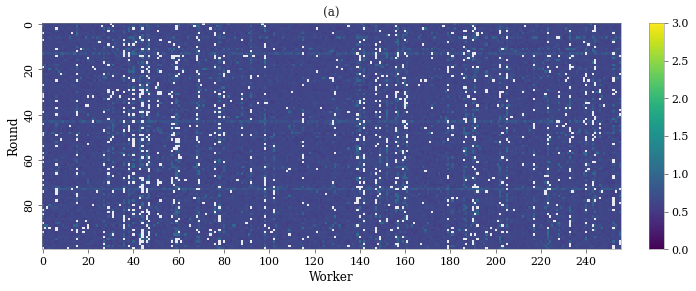

In [4]:
wait_time = durs.min(axis=0) * (1 + mu)

fig, axs = plt.subplots(1, 2, figsize=(10, 4),
                        gridspec_kw={"width_ratios":[1, 0.025]},
                        tight_layout=True)

# Heatmap
sns.heatmap(durs.T, mask=durs.T > wait_time[:, None], ax=axs[0], 
            yticklabels=20, xticklabels=20, cbar_ax=axs[1], cmap='viridis',
            vmin=0, vmax=3, square=True)

axs[0].set(ylabel='Round', xlabel='Worker', title='(a)')

for ax in axs.flat:
    ax.spines.right.set_visible(True)
    ax.spines.left.set_visible(True)
    ax.spines.top.set_visible(True)
    ax.spines.bottom.set_visible(True)

# fig.savefig(FIG_DIR / '1.pdf', dpi=1000)

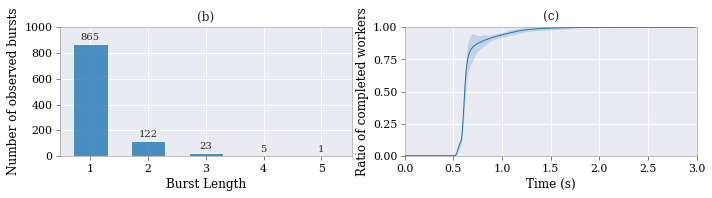

In [5]:
fig, axs = plt.subplots(1, 2, figsize=(10, 2.8),
                        gridspec_kw={"width_ratios":[1, 1]},
                        tight_layout=True)

# Bursts
is_straggler = (durs > wait_time).astype(int)

# pad zero to begining and the end
is_straggler = np.concatenate([
    np.zeros((workers, 1)),
    is_straggler,
    np.zeros((workers, 1))], axis=1)

diff = np.diff(is_straggler, axis=1)
bursts = np.nonzero(diff == -1)[1] - np.nonzero(diff == 1)[1] 


axs[0].bar(*np.unique(bursts, return_counts=True),
           width=0.6, color='tab:blue', edgecolor='w', linewidth=1, alpha=0.8)

axs[0].bar_label(axs[0].containers[0], padding=2)
axs[0].set(ylim=(0, 1000), title='(b)',
           xlabel='Burst Length', ylabel='Number of observed bursts')
axs[0].grid(True)


bins = np.arange(0, 3, 0.01)
dur_cdf = np.array([cdf(dur, bins) for dur in durs.T])


axs[1].plot(bins[:-1], dur_cdf.mean(axis=0), lw=1, c='tab:blue')
axs[1].fill_between(x=bins[:-1], 
                    y1=dur_cdf.mean(0) + dur_cdf.std(0), y2=dur_cdf.mean(0)-dur_cdf.std(0),
                    alpha=0.2, color='tab:blue', lw=0)

axs[1].set(xlabel='Time (s)', ylabel='Ratio of completed workers', title='(c)',
       xlim=(0, np.round(bins[-1])), ylim=(0-0.005,1+0.005))
axs[1].grid(True)


# fig.savefig(FIG_DIR / '2.pdf')


# 1. Probing Profile

In [8]:
folder = 'sam-gc-cnn_profile_est_desktop_long4_new'

workers, invokes, profile_loads, batch, comp_type, regions = folder_params(folder)

# region = 'London'
region = 'Canada'


print(f'{workers=}', f'{invokes=}', f'{profile_loads=}', f'{batch=}', f'{comp_type=}', f'{region=}', sep="\n")

workers=256
invokes=100
profile_loads=[0.0, 0.25, 0.5, 0.75, 1.0]
batch=4096
comp_type='no_forloop'
region='Canada'


In [9]:
# load all profiles

dur_list = []
for load in profile_loads:
    rounds = load_profile(workers, invokes, load, batch, comp_type, region, folder)
    durs = get_durations(rounds).T  
    dur_list.append(durs)
    
dur_list = np.array(dur_list)

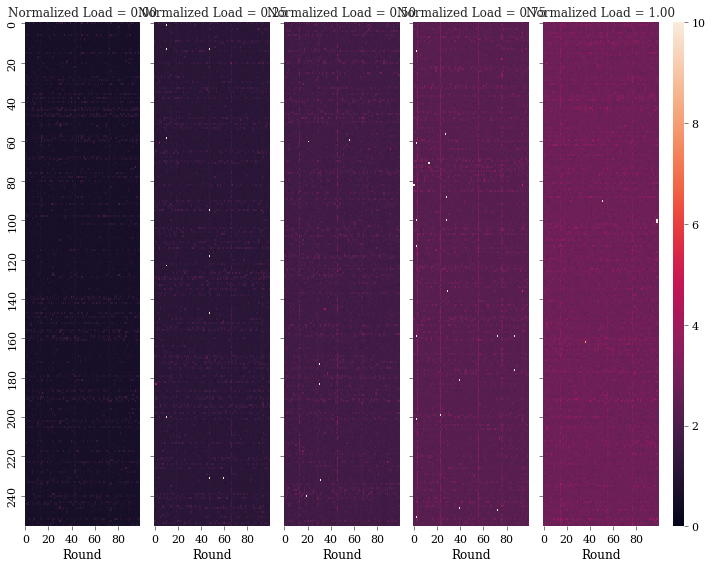

In [7]:
# analyze straggler pattern of each profile

fig, axs = plt.subplots(1, len(profile_loads) + 1, figsize=(10, 8), 
                        gridspec_kw={"width_ratios":[1, 1, 1, 1, 1, 0.1]},
                        tight_layout=True)

for i, (durs, load, ax) in enumerate(zip(dur_list, profile_loads, axs.flat)):
    
    
    sns.heatmap(durs, ax=ax, vmin=0, vmax=10, yticklabels=20, xticklabels=20, cbar_ax=axs[-1])
    ax.set_title(f'Normalized Load = {load:.2f}')
    ax.set_xlabel('Worker')
    ax.set_xlabel('Round')
    ax.tick_params(left=True, bottom=True)
    if i != 0:
        ax.set_yticklabels([])

In [10]:
# FIND BASE_COMP
    
lr = LinearRegression().fit(
    y = np.array(dur_list).reshape(-1,),
    X = np.repeat(profile_loads, dur_list[0].size).reshape(-1, 1)
) 
base_comp = lr.coef_[0]

print(f'{base_comp = :.4f}')

base_comp = 2.2013


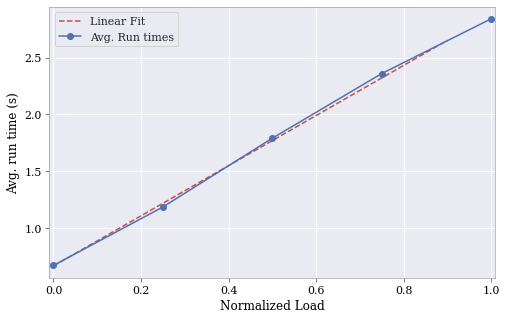

In [10]:
# Plot linear regression

fig, ax = plt.subplots(figsize=(8, 5))
ax.errorbar(x=profile_loads,
            y=[d.mean() for d in dur_list],
       #      yerr=[d.std() for d in dur_list],
            label='Avg. Run times', marker='o'
)

x = np.arange(0, 1, 0.1)
y = x * lr.coef_[0] + lr.intercept_
ax.plot(x, y, 'r--', label='Linear Fit')

ax.set(xlabel = 'Normalized Load',
       ylabel = 'Avg. run time (s)',
       xlim=(0-0.01, 1+0.01),
     #   ylim=(0, 3)
)
# ax.set_title(f'{base_comp=}')
ax.grid(True)
ax.legend()


# Ridge plot

# l = np.array([[l] * dur_list[0].size for l in profile_loads]).flatten()
# x = np.array(dur_list).flatten()
# sel = x < 10
# x = x[sel]
# l = l[sel]
# ridge_plot(x, l, bw_adjust=3, xlabel='completion time (s)');


# fig.savefig(FIG_DIR/'5.pdf', bbox_inches='tight')



# 2. Selecting Scheme Parameters 

In [11]:
#  LOAD BASE (REFERENCE) PROFILE

folder = 'sam-gc-cnn_profile_est_desktop_long4_new'

n_jobs = 80  # number of jobs to complete
# n_jobs = 10  # number of jobs to complete
base_load = 0.0
mu = 1.0
base_comp = 2.2013

# max_delay = invokes - n_jobs  # total number of rounds profiled - number of jobs to complete
max_delay = 4

rounds = load_profile(workers, invokes, base_load, batch, comp_type, region, folder)
base_delays = get_durations(rounds).T # (workers, rounds)

In [45]:
# RUN ALL PARAMS: 

def find_runtime(Model, params):
    
    # sclae delay profile based on normalized load used.
    load = Model.normalized_load(workers, *params)
    delays = base_delays + (load - base_load) * base_comp
    
    # run the model and get the duration
    model = Model(workers, *params, n_jobs, mu, delays)
    model.run()
    durations = model.durations
    
    assert (durations >= 0).all()
    return durations.sum()


runtimes_df = []
for model_name, Model in models.items():
    params_combinations = list(Model.param_combinations(workers, n_jobs, max_delay))
    loads = [Model.normalized_load(workers, *params) for params in params_combinations]
    runtimes = [find_runtime(Model, params) for params in tqdm(params_combinations)]
    
    runtimes_df += zip(repeat(model_name), runtimes, loads, params_combinations)
    
runtimes_df = pd.DataFrame(runtimes_df, columns=['model_name', 'runtime', 'load', 'params'])

df = runtimes_df.loc[runtimes_df.groupby('model_name')['runtime'].idxmin()]
df = df.set_index('model_name')
df

  0%|          | 0/256 [00:00<?, ?it/s]

  0%|          | 0/4608 [00:00<?, ?it/s]

  0%|          | 0/1024 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

,runtime,load,params
model_name,,,
GC,12.693817,0.039062,"(9,)"
MSGC,12.993730,0.007512,"(1, 2, 24)"
No Coding,14.665613,0.003906,()
SRSGC,12.359897,0.035156,"(4, 9, 22)"


In [46]:
# save estimated runtimes
fname = f'mu{slugify(mu)}-base_load{slugify(base_load)}-njobs{n_jobs}-base_comp{slugify(base_comp)}-{region}'
fpath = (DELAY_DIR / folder / fname).with_suffix('.csv')
df.to_csv(fpath)    

fname += '_all'
fpath = (DELAY_DIR / folder / fname).with_suffix('.csv')
runtimes_df.to_csv(fpath)

In [12]:
# load estimated runtimes

fname = f'mu{slugify(mu)}-base_load{slugify(base_load)}-njobs{n_jobs}-base_comp{slugify(base_comp)}-{region}'

fpath = (DELAY_DIR / folder / fname).with_suffix('.csv')
df = pd.read_csv(fpath, index_col='model_name', converters={"params": ast.literal_eval})  
df = df.sort_values(by=['runtime'])

fname += '_all'
fpath = (DELAY_DIR / folder / fname).with_suffix('.csv')
runtimes_df = pd.read_csv(fpath, index_col=0, converters={"params": ast.literal_eval})

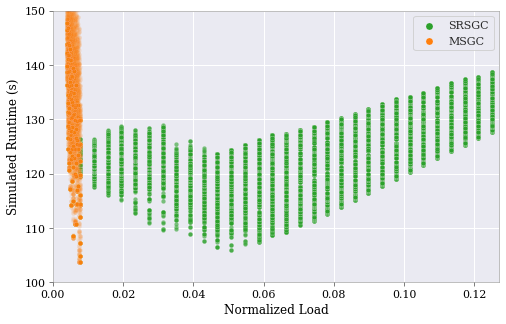

In [52]:
fig, ax = plt.subplots(figsize=(8, 5))

alpha = {
    'GC': 1,
    'SRSGC': 0.6,
    'MSGC': 0.1,
    'No Coding': 1,
}
size = {
    'GC': 65,
    'SRSGC': 20,
    'MSGC': 20,
    'No Coding': 50,
}

for model_name in models:
    if model_name in ['GC', 'No Coding']:
        continue
    
    model_time = runtimes_df[runtimes_df['model_name']==model_name]
    sns.scatterplot(data=model_time,
                    x="load", y="runtime",
                    linewidth=0, alpha=alpha[model_name], 
                    color=colors[model_name], s=size[model_name], label=model_name, lw=0.2)

ax.set_xlabel('Normalized Load')
ax.set_ylabel(f'Simulated Runtime (s)')
# ax.set_title(f'{workers=} {region=} {mu=} {n_jobs=} ')

ax.grid(True)

ax.set_ylim(100, 150)
ax.set_xlim(0, 0.127)

leg = ax.legend()
for lh in leg.legendHandles: 
    lh.set_alpha(1)
    lh.set_sizes([50])

# fig.savefig(FIG_DIR/'6.png', dpi=600)

In [23]:
runtimes_df

B, W, lambd = zip(*runtimes_df[runtimes_df['model_name']=='SRSGC']['params'])
runtimes = runtimes_df[runtimes_df['model_name']=='SRSGC']['runtime']

In [63]:
np.unique(lambd)

array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
        14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,
        27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,
        40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,
        53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,
        66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,
        79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,
        92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103, 104,
       105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117,
       118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130,
       131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143,
       144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156,
       157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169,
       170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 18

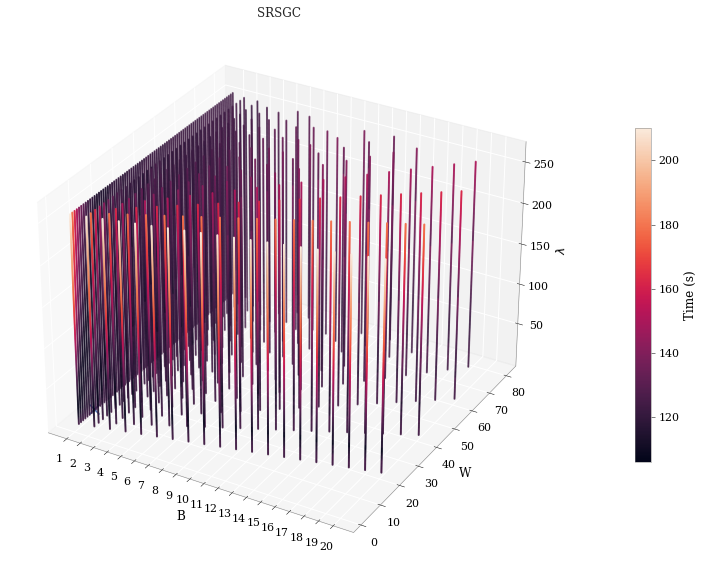

In [92]:
model_name = 'SRSGC'
 
params = runtimes_df[runtimes_df['model_name']==model_name]['params'].to_numpy()
B, W, lambd = zip(*params)
runtimes = runtimes_df[runtimes_df['model_name']==model_name]['runtime']

fig = plt.figure(figsize=(15, 10), facecolor='w')
ax = fig.add_subplot(projection='3d')

sc = ax.scatter3D(B, W, lambd, c=runtimes, s=1)
ax.scatter3D(*params[np.argmin(runtimes)], marker='x', s=100)

ax.set(xlabel='B', ylabel='W', zlabel='$\lambda$',
       title=model_name,
       xticks=np.unique(B), yticks=np.arange(0, max(W)+1, 10),
       zlim=(1, None))

ax.set_facecolor('w')
fig.colorbar(sc, ax=ax, fraction=0.02, pad=0.1, label='Time (s)')

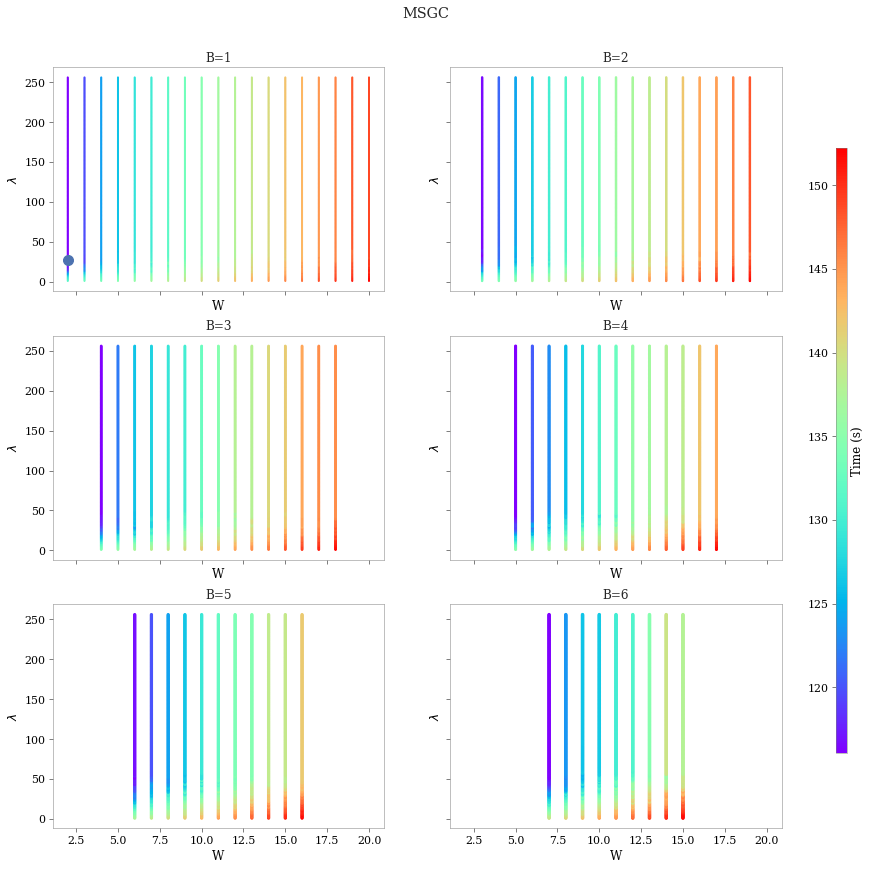

In [186]:
# model_name = 'SRSGC'
model_name = 'MSGC'

B_range = np.arange(1, 7)

fig, axs = plt.subplots(3, 2, figsize=(15, 14), sharex=True, sharey=True)

params = runtimes_df[runtimes_df['model_name']==model_name]['params'].to_numpy()
runtimes = runtimes_df[runtimes_df['model_name']==model_name]['runtime']
B, W, lambd = zip(*params)
B = np.array(B)
W = np.array(W)
lambd = np.array(lambd)

best_params = params[np.argmin(runtimes)]

for ax, b in zip(axs.flat, B_range):
       idx = (B == b)
       sc = ax.scatter(W[idx], lambd[idx], c=runtimes[idx], s=b, cmap='rainbow')
       ax.set(xlabel='W', ylabel='$\lambda$', title=f'B={b}',
               facecolor='w')
       if b == best_params[0]:
              ax.scatter(best_params[1], best_params[2], marker='o', s=100)

fig.suptitle(model_name, x=0.47, y=0.94)

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.2, 0.01, 0.6])
fig.colorbar(sc, cax=cbar_ax, fraction=0.02, pad=0.1, label='Time (s)')
cbar_ax.yaxis.set_ticks_position('left')


In [14]:
# best params
df.sort_values(by=['runtime'])

,runtime,load,params
model_name,,,
MSGC,103.727155,0.007543,"(1, 2, 27)"
SRSGC,105.924997,0.050781,"(2, 3, 23)"
GC,109.358945,0.062500,"(15,)"
No Coding,122.638171,0.003906,()


# Rebuttal

## Different Probing Profile Lengths

In [5]:
#  LOAD BASE (REFERENCE) PROFILE

folder = 'sam-gc-cnn_profile_est_desktop_long4_new'

# n_jobs = 80  # number of jobs to complete
n_jobs = 10  # number of jobs to complete
base_load = 0.0
mu = 1.0

# max_delay = invokes - n_jobs  # total number of rounds profiled - number of jobs to complete
max_delay = 4
base_comp = 2.2013

rounds = load_profile(workers, invokes, base_load, batch, comp_type, region, folder)
base_delays = get_durations(rounds).T # (workers, rounds)

In [6]:
# load all params for all num_jobs

dfs = []
for n_jobs in (10, 20, 40, 60, 80):
    fname = f'mu{slugify(mu)}-base_load{slugify(base_load)}-njobs{n_jobs}-base_comp{slugify(base_comp)}-{region}'
    fpath = (DELAY_DIR / folder / fname).with_suffix('.csv')
    
    df = pd.read_csv(fpath, converters={"params": ast.literal_eval})
    df = df.sort_values(by=['runtime'])
    df['probe_len'] = n_jobs
    dfs.append(df)
    
df = pd.concat(dfs).sort_values(by=['model_name', 'probe_len']).reset_index(drop=True)
df = df.loc[:, ['model_name', 'probe_len', 'params',  'load', 'runtime']]
df

,model_name,probe_len,params,load,runtime
0,GC,10,"(9,)",0.039062,12.693817
1,GC,20,"(10,)",0.042969,26.448834
2,GC,40,"(11,)",0.046875,54.075883
3,GC,60,"(14,)",0.058594,82.048731
4,GC,80,"(15,)",0.062500,109.358945
5,MSGC,10,"(1, 2, 24)",0.007512,12.993730
6,MSGC,20,"(1, 2, 24)",0.007512,25.676248
7,MSGC,40,"(1, 2, 27)",0.007543,51.801946
8,MSGC,60,"(1, 2, 27)",0.007543,78.054788
9,MSGC,80,"(1, 2, 27)",0.007543,103.727155


In [7]:
folder = 'sam-gc-cnn_profile_est_desktop_long4_new'

folder_real = folder + '_real_2'
invokes = 500
# invokes = 400
mu = 1
# max_delay = 20


loads = df[df['probe_len']==80]['load'].to_numpy()

# load all real profiles
dur_list = []
for load in loads:
    rounds = load_profile(workers, invokes, load, batch, comp_type, region, folder_real)
    durs = get_durations(rounds).T    
    dur_list.append(durs)
dur_list = np.array(dur_list)


n_jobs = 480  # number of jobs to complete

In [10]:
#%% MULTIPLE RUNS

np.random.seed(10)

# num_tries = 1
num_tries = 5
# num_splits = 20

for i, row in df.iterrows():
    load = row['load']
    model_name = row['model_name']
    load_used = loads[np.abs(loads - load).argmin()]
    
    runtimes = []
    for n in range(num_tries):
        rounds = load_profile(workers, invokes, load_used, batch, comp_type, region, folder_real, suffix=n)
        durs = get_durations(rounds).T
        
        durs += (load - load_used)  * base_comp

        model = models[model_name](workers, *row['params'], n_jobs, mu, durs)
        model.run()
        runtimes.append(model.durations.sum())
    
    total_runtime = f'{np.mean(runtimes):.2f} ± {np.std(runtimes):.2f} (s)'
    # total_runtime = f'{np.mean(runtimes):.2f} (s)'
    df.loc[i, 'runtime'] = total_runtime
        


## Decoding Time

In [45]:
from pathlib import Path
import io
from pydoc import cli

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import numpy as np
import boto3

import coding

DATAPATH = Path.home() / '.datasets'


class CnnModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Conv2d(1, 8, 5), nn.ReLU(),
            nn.Conv2d(8, 16, 5), nn.ReLU(),
            nn.Conv2d(16, 4, 5), nn.ReLU(),
            nn.Flatten(),
            nn.Linear(1024, 256), nn.ReLU(),
            nn.Linear(256, 10),
        )

    def forward(self, x):
        return self.layers(x)
    

model = CnnModel()
# num_params = sum(p.numel() for p in model.parameters())
# print(f'simple cnn: {num_params=:,}, size (float16) = {num_params * 16 / 8:,} B')


# load dataset
transform = torchvision.transforms.ToTensor()
ds = torchvision.datasets.MNIST(root=DATAPATH,
                                  train=True,
                                  download=True,
                                  transform=transform)

batch_size = 256
loader = torch.utils.data.DataLoader(ds, batch_size=batch_size)
x, y = next(iter(loader))


#%% find grads
y_logit = model(x)
loss = F.cross_entropy(y_logit, y)
loss.backward()
# grads = [p.grad.numpy().astype(np.float16) for p in model.parameters()]
grads = [p.grad.numpy() for p in model.parameters()]


In [60]:
def gc_decode(n, s, B, is_straggler, task_results):
    a = coding.find_coef(B, s, is_straggler)
    a = a[a != 0]

    sum_grads = []
    for g in zip(*task_results):
        sum_grads.append((a * np.stack(g, axis=-1)).sum(axis=-1))
    
    return sum_grads

In [95]:
n = 256
s = 27

task_results = [grads] * (n-s)

B = coding.get_B(n, s)
is_straggler = np.zeros((n, ), dtype=bool)
is_straggler[:s] = True

In [96]:
%%timeit -r 480 -n 1 -o
sum_grads = gc_decode(n, s, B, is_straggler, task_results)

290 ms ± 18.7 ms per loop (mean ± std. dev. of 480 runs, 1 loop each)


<TimeitResult : 290 ms ± 18.7 ms per loop (mean ± std. dev. of 480 runs, 1 loop each)>

In [97]:
t = _
t.worst

0.4791331249871291

## Switching to coded schemes

In [4]:
# use no coding as prob lenth

#  LOAD BASE (REFERENCE) PROFILE
folder = 'sam-gc-cnn_profile_est_desktop_long4_new_real_2'

probe_jobs = 80  # number of jobs to complete
probe_load = 0.003906 # 1/n: load for no coding

n_jobs = 480  # number of jobs to complete
base_loads = np.array([0.003906, 0.062500, 0.007543, 0.050781])


invokes = 500
mu = 1.0
workers = 256
batch = 4096
comp_type = 'no_forloop'
region = 'Canada'


max_delay = 4
base_comp = 2.2013


def find_runtime(Model, params, prob_delay, probe_load, probe_jobs):
    # sclae delay profile based on normalized load used.
    load = Model.normalized_load(workers, *params)
    delays = prob_delay + (load - probe_load) * base_comp

    # run the model and get the duration
    model = Model(workers, *params, probe_jobs, mu, delays)
    model.run()
    durations = model.durations

    assert (durations >= 0).all()
    return durations.sum()

In [15]:
#%% MULTIPLE RUNS
np.random.seed(10)
num_tries = 10

runtimes = {}

for n in trange(num_tries):
    # load probe profile
    probe_rounds = load_profile(workers, invokes, probe_load, batch, comp_type,
                            region, folder, suffix=n)
    prob_delay = get_durations(probe_rounds).T # (workers, rounds)

    no_coding = NoCoding(workers, probe_jobs, mu, prob_delay)
    no_coding.run()
    uncoded_durations = no_coding.durations
    
    for model_name, Model in models.items():
        runtimes[model_name] = runtimes.get(model_name, list())     
        
        # find best parameters
        max_W = 5
        if model_name in ('MSGC', 'SRSGC'):
            params_combinations = list(
                Model.param_combinations(workers, probe_jobs, max_delay, max_W))
        else:
            params_combinations = list(
                Model.param_combinations(workers, probe_jobs, max_delay))
            
        _runtimes = [find_runtime(Model, params, prob_delay, probe_load, probe_jobs)
                     for params in tqdm(params_combinations, desc=model_name)]
        best_params = params_combinations[np.argmin(_runtimes)]

        # switch
                
        # use the profile based on load from best parameters
        load = Model.normalized_load(workers, *best_params)
        load_used = base_loads[np.abs(base_loads - load).argmin()]

        rounds = load_profile(workers, invokes, load_used, batch, comp_type,
                              region, folder, suffix=n)
        durs = get_durations(rounds).T
        durs = durs[:, probe_jobs:]
        
        durs += (load - load_used) * base_comp

        model = Model(workers, *best_params, n_jobs - probe_jobs, mu, durs)
        model.run()
        r = np.concatenate((uncoded_durations, model.durations), axis=0)
        runtimes[model_name].append(r)

  0%|          | 0/10 [00:00<?, ?it/s]

GC:   0%|          | 0/256 [00:00<?, ?it/s]

SRSGC:   0%|          | 0/2048 [00:00<?, ?it/s]

MSGC:   0%|          | 0/1024 [00:00<?, ?it/s]

No Coding:   0%|          | 0/1 [00:00<?, ?it/s]

GC:   0%|          | 0/256 [00:00<?, ?it/s]

SRSGC:   0%|          | 0/2048 [00:00<?, ?it/s]

MSGC:   0%|          | 0/1024 [00:00<?, ?it/s]

No Coding:   0%|          | 0/1 [00:00<?, ?it/s]

GC:   0%|          | 0/256 [00:00<?, ?it/s]

SRSGC:   0%|          | 0/2048 [00:00<?, ?it/s]

MSGC:   0%|          | 0/1024 [00:00<?, ?it/s]

No Coding:   0%|          | 0/1 [00:00<?, ?it/s]

GC:   0%|          | 0/256 [00:00<?, ?it/s]

SRSGC:   0%|          | 0/2048 [00:00<?, ?it/s]

MSGC:   0%|          | 0/1024 [00:00<?, ?it/s]

No Coding:   0%|          | 0/1 [00:00<?, ?it/s]

GC:   0%|          | 0/256 [00:00<?, ?it/s]

SRSGC:   0%|          | 0/2048 [00:00<?, ?it/s]

MSGC:   0%|          | 0/1024 [00:00<?, ?it/s]

No Coding:   0%|          | 0/1 [00:00<?, ?it/s]

GC:   0%|          | 0/256 [00:00<?, ?it/s]

SRSGC:   0%|          | 0/2048 [00:00<?, ?it/s]

MSGC:   0%|          | 0/1024 [00:00<?, ?it/s]

No Coding:   0%|          | 0/1 [00:00<?, ?it/s]

GC:   0%|          | 0/256 [00:00<?, ?it/s]

SRSGC:   0%|          | 0/2048 [00:00<?, ?it/s]

MSGC:   0%|          | 0/1024 [00:00<?, ?it/s]

No Coding:   0%|          | 0/1 [00:00<?, ?it/s]

GC:   0%|          | 0/256 [00:00<?, ?it/s]

SRSGC:   0%|          | 0/2048 [00:00<?, ?it/s]

MSGC:   0%|          | 0/1024 [00:00<?, ?it/s]

No Coding:   0%|          | 0/1 [00:00<?, ?it/s]

GC:   0%|          | 0/256 [00:00<?, ?it/s]

SRSGC:   0%|          | 0/2048 [00:00<?, ?it/s]

MSGC:   0%|          | 0/1024 [00:00<?, ?it/s]

No Coding:   0%|          | 0/1 [00:00<?, ?it/s]

GC:   0%|          | 0/256 [00:00<?, ?it/s]

SRSGC:   0%|          | 0/2048 [00:00<?, ?it/s]

MSGC:   0%|          | 0/1024 [00:00<?, ?it/s]

No Coding:   0%|          | 0/1 [00:00<?, ?it/s]

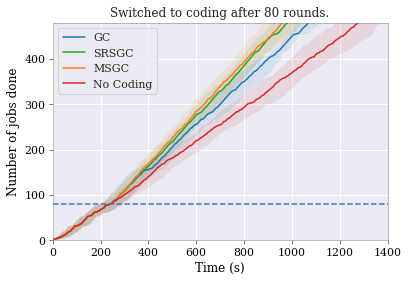

In [16]:
fig, ax = plt.subplots()
# n = 0
for model_name, r in runtimes.items():
    times = []
    for t in r:
        t1, t2 = t[:probe_jobs], t[probe_jobs:]
        t1 = t1.cumsum() 
        t2 = t2.cumsum()[-(n_jobs-probe_jobs):] + t1[-1]
        times.append(np.concatenate((t1, t2), axis=0))
    
    
    ax.plot(np.mean(times, axis=0), np.arange(n_jobs)+1, 
            label=model_name, c=colors[model_name])
    ax.fill_betweenx(y=np.arange(n_jobs)+1, 
                     x1=np.mean(times, axis=0) + np.std(times, axis=0),
                     x2=np.mean(times, axis=0) - np.std(times, axis=0),
                     lw=0.2, alpha=0.1, color=colors[model_name])

    
ax.axhline(probe_jobs+1, ls='--')    
ax.legend()
ax.set(xlabel='Time (s)', ylabel= 'Number of jobs done',
       xlim=(0, 1400), ylim=(0, n_jobs), title=f'Switched to coding after {probe_jobs} rounds.');


# 3. Real Runtimes

In [15]:
folder = 'sam-gc-cnn_profile_est_desktop_long4_new'

folder_real = folder + '_real_2'
invokes = 500
# invokes = 400
mu = 1


In [16]:
# load all real profiles

dur_list = []
for load in df['load']:
    rounds = load_profile(workers, invokes, load, batch, comp_type, region, folder_real)
    durs = get_durations(rounds).T    
    dur_list.append(durs)
dur_list = np.array(dur_list)


n_jobs = dur_list[0].shape[1] - max_delay  # number of jobs to complete

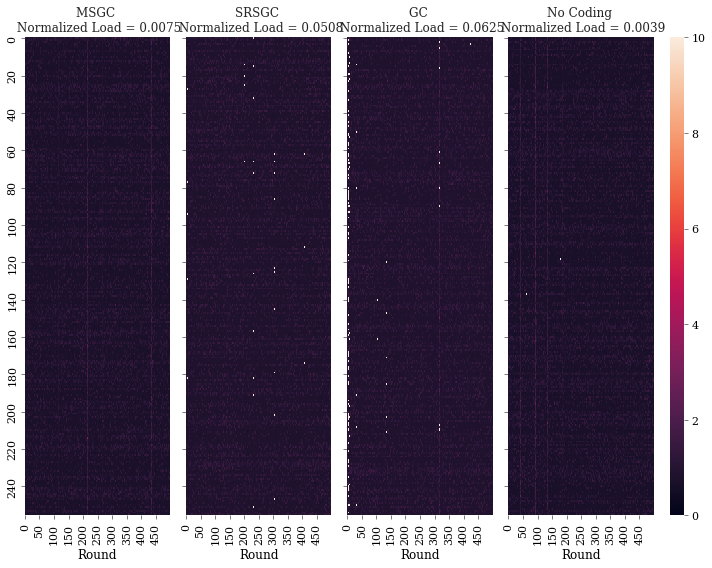

In [18]:
fig, axs = plt.subplots(1, len(dur_list) + 1, figsize=(10, 8), 
                        gridspec_kw={"width_ratios":[1, 1, 1, 1, 0.1]},
                        tight_layout=True)

for i, (durs, load, ax, model_name) in enumerate(zip(dur_list, df['load'], axs.flat, df.index)):
    
    sns.heatmap(durs, ax=ax, vmin=0, vmax=10, yticklabels=20, xticklabels=50, cbar_ax=axs[-1])
    ax.set_title(f'{model_name} \n Normalized Load = {load:.4f}')
    ax.set_xlabel('Worker')
    ax.set_xlabel('Round')
    ax.tick_params(left=True, bottom=True)
    if i != 0:
        ax.set_yticklabels([])

In [29]:
#%% MULTIPLE RUNS

np.random.seed(10)    

num_tries = 10
# num_splits = 20

runtimes = {}
for model_name, durs, load in zip(df.index, dur_list, df['load']):
    
    _runtimes = {'total': [], 'rounds': [], 'wait_outs': [], 'duration':[]}
    
    for n in range(num_tries):            
        rounds = load_profile(workers, invokes, load, batch, comp_type, region, folder_real, suffix=n)
        durs = get_durations(rounds).T

        best_params = df.loc[model_name, 'params']

        model = models[model_name](workers, *best_params, n_jobs, mu, durs)
        model.run()
        durations = model.durations
        
        _x = durations[durations>0].cumsum()[-n_jobs:]
        _runtimes['rounds'].append(_x)
        _runtimes['duration'].append(durations[durations>0])
        _runtimes['total'].append(durations.sum())
        _runtimes['wait_outs'].append(model.num_waits)
        
        
        
    runtimes[model_name] = _runtimes

In [38]:
df = df[['load', 'params']]
for model_name in df.index:
    runtime_mean = np.mean(runtimes[model_name]['total'])
    runtime_std = np.std(runtimes[model_name]['total'])

    df.loc[model_name, 'runtime'] = f'{runtime_mean:.2f} ± {runtime_std:.2f} (s)'
    df.loc[model_name, 'wait_outs'] = np.mean(runtimes[model_name]['wait_outs'])
    df.loc[model_name, 'fastest_round'] = np.concatenate(runtimes[model_name]['duration']).min() * 1000
    
    
display(df)

,load,params,runtime,wait_outs,fastest_round
model_name,,,,,
MSGC,0.007543,"(1, 2, 27)",916.37 ± 63.14 (s),295.8,1177.8676
SRSGC,0.050781,"(2, 3, 23)",1019.46 ± 49.92 (s),242.4,1349.5974
GC,0.062500,"(15,)",1095.14 ± 50.66 (s),129.0,1379.9380
No Coding,0.003906,(),1321.18 ± 86.84 (s),496.0,1287.5668


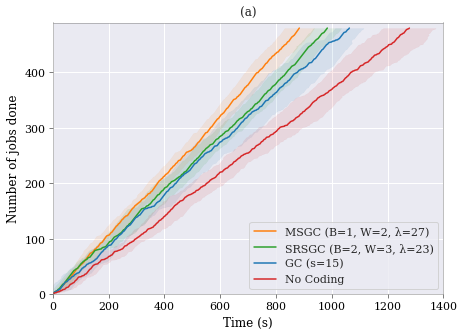

In [26]:
fig, ax = plt.subplots(figsize=(7, 5))

for model_name in df.index:
    p = df.loc[model_name, 'params']
    
    if np.isnan(p).all():
        p = tuple()
        
    if len(p) == 3:
        B, W, l = p
        p = f'(B={B}, W={W}, λ={l})'
    elif len(p) == 1:
        p = f'(s={p[0]})'
    elif len(p) == 0:
        p = ''
        
    times = np.array(runtimes[model_name]['rounds'])
    

    ax.plot(times.mean(axis=0), np.arange(n_jobs)+1, 
            label=f'{model_name} {p}', c=colors[model_name])
    ax.fill_betweenx(y=np.arange(n_jobs)+1, 
                     x1=times.mean(0) + times.std(0), x2=times.mean(0) - times.std(0),
                     lw=0.2, alpha=0.1, color=colors[model_name])
    # for time in times:
    #     ax.plot(time, np.arange(n_jobs)+1, c=colors[model_name], lw=0.1, ls='-.')

ax.grid(True)
ax.legend()
ax.set(xlabel='Time (s)', ylabel= 'Number of jobs done',
       xlim=(0, 1400), ylim=(0, 490), title='(a)');
# ax.set_rasterized(True)

# fig.savefig(FIG_DIR / '3.pdf')


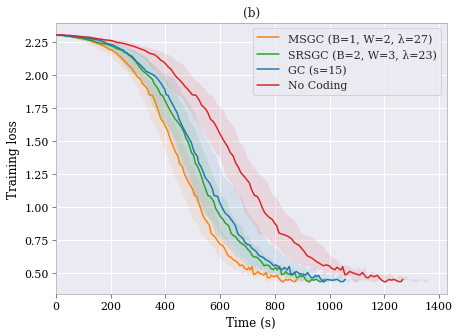

In [23]:
with open('./train_acc.pkl', 'rb') as f:
    train_acc, train_loss = pickle.load(f)

fig, ax = plt.subplots(figsize=(7, 5))
for model_name in df.index:
    p = df.loc[model_name, 'params']

    if np.isnan(p).all():
        p = tuple()

    
    if len(p) == 3:
        B, W, l = p
        p = f'(B={B}, W={W}, λ={l})'
    elif len(p) == 1:
        p = f'(s={p[0]})'
    elif len(p) == 0:
        p = ''
        
    times = np.array(runtimes[model_name]['rounds'])
    times = times[:, ::4]
    
    
    # print(times.shape)
    ax.plot(times.mean(0), train_loss[:times.shape[1]],
            label=f'{model_name} {p}', c=colors[model_name])
    
    ax.fill_betweenx(y=train_loss[:times.shape[1]], 
                     x1=times.mean(0) + times.std(0), x2=times.mean(0) - times.std(0),
                     lw=0.2, alpha=0.1, color=colors[model_name])
    
    # for time in times:
    #     ax.plot(time, train_acc[:len(time)], alpha=1, c=colors[model_name], lw=0.1, ls='-.')

ax.grid(True)
ax.legend()
ax.set(xlabel='Time (s)', ylabel= 'Training loss',
       xlim=(0, None), title='(b)');

# fig.savefig(FIG_DIR / '4.pdf')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


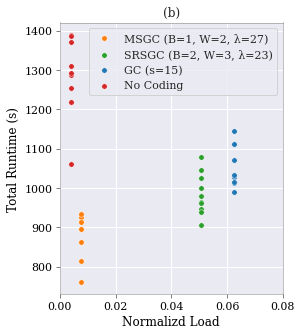

In [24]:
fig, ax = plt.subplots(figsize=(4, 5))

for model_name, load, p in zip(df.index, df['load'], df['params']):
    r = runtimes[model_name]['total']
    if len(p) == 3:
        B, W, l = p
        p = f'(B={B}, W={W}, λ={l})'
    elif len(p) == 1:
        p = f'(s={p[0]})'
    elif len(p) == 0:
        p = ''
    ax.scatter([load]*len(r), r, c=colors[model_name],
               edgecolors='w', linewidths=0.5, s=30, 
               label=f'{model_name} {p}')

    # sns.violinplot(data=pd.DataFrame(runtimes) , inner="points", orient="v")
ax.legend()
ax.grid(True)
ax.set(ylabel='Total Runtime (s)', xlabel='Normalizd Load',
       xlim=(0, 0.08), title='(b)')

# fig.savefig(FIG_DIR / '4.eps', bbox_inches='tight')